In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv
/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv
/kaggle/input/multilabel-video-game-dataset-v2/vgame_fulldata.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import STOPWORDS
import gc
import re
import operator
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# 📌 Data Import and Validation
---

### 📝 Import Data and Check Data Distribution

In [3]:
# train df
X_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_train.csv')
y_train = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_train.csv')

# test df
X_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_test.csv')
y_test = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_test.csv')

# val df
X_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/X_val.csv')
y_val = pd.read_csv('/kaggle/input/multilabel-video-game-dataset-v2/y_val.csv')

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')

X_train shape: (117197, 2)
y_train shape: (117197, 12)

X_val shape: (14650, 2)
y_val shape: (14650, 12)

X_test shape: (14650, 2)
y_test shape: (14650, 12)



### 📝 Tiny EDA for Train, Test, and Validation Set

In [5]:
from ast import literal_eval

y_train['new_genrelist'] = y_train['new_genrelist'].apply(literal_eval)
y_test['new_genrelist'] = y_test['new_genrelist'].apply(literal_eval)
y_val['new_genrelist'] = y_val['new_genrelist'].apply(literal_eval)

In [6]:
genre_cols = ['action','adventure','arcade','cardboard','indie','puzzle','quiz','rpg','simulation','strategy']

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.798954,0.633864,0.916517,0.985588,0.566269,0.884792,0.992491,0.862104,0.737425,0.813818
1,0.201046,0.366136,0.083483,0.014412,0.433731,0.115208,0.007509,0.137896,0.262575,0.186182


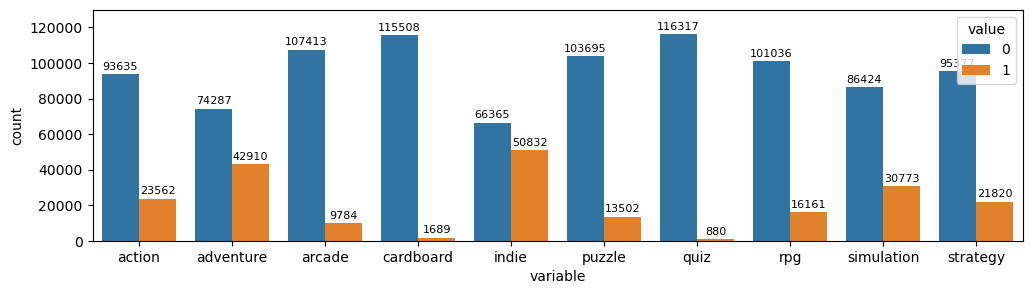

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

display(y_train[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_train[genre_cols]))
ax.set_ylim(0,130000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

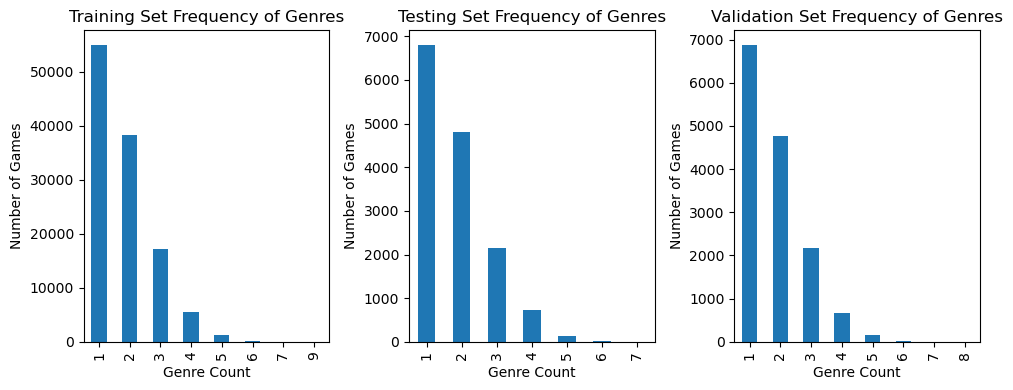

In [8]:
def freq_counter(df):
    freq_count = df['new_genrelist'].apply(len)
    return freq_count.value_counts()

training_freqcount = freq_counter(y_train)
testing_freqcount = freq_counter(y_test)
validation_freqcount = freq_counter(y_val)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
training_freqcount.plot(kind='bar', title='Training Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax1)
testing_freqcount.plot(kind='bar', title='Testing Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax2)
validation_freqcount.plot(kind='bar', title='Validation Set Frequency of Genres', xlabel='Genre Count', ylabel='Number of Games', ax=ax3)
plt.tight_layout()

### 📝 Compile genre tags binary results to list then merge

In [9]:
y_train['compiled_genrelist'] = y_train[genre_cols].values.tolist()
y_val['compiled_genrelist'] = y_val[genre_cols].values.tolist()

merged_trainset = pd.merge(X_train, y_train, on='id')[['clean_summary', 'compiled_genrelist']]
merged_valset = pd.merge(X_val, y_val, on='id')[['clean_summary', 'compiled_genrelist']]

In [10]:
display(merged_trainset)
display(merged_valset)

,clean_summary,compiled_genrelist
0,a grid based single local multiplayer strategy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,top view racing game for wiiware by the makers...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,the idolmaster dearly stars is a japanese life...,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]"
3,my daughter who was supposed to be dead is rig...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]"
4,espn baseball tonight is a baseball game with ...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
...,...,...
117192,kero kero king is the predecessor to ribbit ki...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117193,mighty chameleon brothers will remind you of o...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
117194,take control of one of the iconic british loco...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
117195,alchemist of war is a casual card game with cr...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


,clean_summary,compiled_genrelist
0,a new legend begins here build and manage a to...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 1]"
1,meet barnsley a lazy good for nothing badger w...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,fire up a wild ride across the cosmos with a f...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0]"
3,a special bonus disc that contained the both t...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,kings cross a unique mix of strategy rpg and t...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
...,...,...
14645,own the child of light ultimate edition with t...,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 1]"
14646,a side scroller adventure game with a slight t...,"[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]"
14647,welcome to the chess game of tomorrow yesterye...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1]"
14648,a capcom developed adventure game released exc...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


# 📌 Handling Dataset Imbalance
---

# 📌 Preparation for Modelling
---

### 📝 Defining the Dataset Class

In [11]:
from torch.utils.data import Dataset, DataLoader

class MultiLabelDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_len, new_data=False):
        self.tokenizer = tokenizer
        self.data = df
        self.text = df.clean_summary
        self.new_data = new_data
        self.max_len = max_len
        
        if not new_data:
            self.targets = self.data.compiled_genrelist
            
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        
        inputs = self.tokenizer.encode_plus(text,None,
                                           add_special_tokens=True,
                                           max_length=self.max_len,
                                           pad_to_max_length=True,
                                           return_token_type_ids=True)
        out = {
            "input_ids": torch.tensor(inputs['input_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(inputs['attention_mask'], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }
        if not self.new_data:
            out["targets"] = torch.tensor(self.targets[index], dtype=torch.float)
            
        return out

### 📝 Defining the Configuration

In [12]:
MAX_LEN = 320
EPOCHS = 5
LEARNING_RATE = 1e-05
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

### 📝 Setting the Seeds

In [13]:
import os
import random
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### 📝 Tokenizing and Creating Dataset then Loading it to the DataLoader

In [14]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
train_set = MultiLabelDataset(merged_trainset, tokenizer, MAX_LEN)
val_set = MultiLabelDataset(merged_valset, tokenizer, MAX_LEN)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=8)

# 📌 Model Development
---

### 📝 Defining DistilBERT Class Model

In [15]:
from transformers import DistilBertModel

class DistilBertClass(torch.nn.Module):
    def __init__(self):
        super(DistilBertClass, self).__init__()
        
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 768),
                                             torch.nn.ReLU(),
                                             torch.nn.Dropout(0.1),
                                             torch.nn.Linear(768, 10))
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        out = hidden_state[:,0]
        out = self.classifier(out)
        return out

### 📝 Initializing the Model and Moving it to GPU

In [16]:
model = DistilBertClass()
model.to(DEVICE)
print(f"Model on {DEVICE}")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model on cuda:0


### 📝 Defining Optimizer and Loss Function

In [17]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

def focal_loss(outputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
    p_t = torch.exp(-bce_loss)
    focal_loss = alpha * (1 - p_t) ** gamma * bce_loss
    if reduction == 'mean':
        return torch.mean(focal_loss)
    elif reduction == 'sum':
        return torch.sum(focal_loss)
    else:
        return focal_loss

def loss_fn(outputs, targets):
#     return torch.nn.functional.binary_cross_entropy_with_logits(outputs,targets)
    return focal_loss(outputs, targets, alpha=0.25, gamma=2.0, reduction='mean')

### 📝 Defining Training Loop

In [18]:
from tqdm.auto import tqdm

loss_values = [[] for i in range(EPOCHS)]

def train(epoch):
    model.train()
    
    for _, data in tqdm(enumerate(train_loader)):
        input_ids = data['input_ids'].to(DEVICE, dtype=torch.long)
        attention_mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        targets = data['targets'].to(DEVICE, dtype=torch.float)
        
        outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        
        if _ % 500 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
            loss_values[epoch].append(loss.item())
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

### 📝 Defining Validation Loop

In [19]:
from sklearn import metrics

def validate():
  model.eval()

  fin_targets = []
  fin_outputs = []

  with torch.inference_mode():
    for _, data in tqdm(enumerate(val_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      targets = data['targets'].to(DEVICE, dtype=torch.float)

      outputs = model(ids, mask, token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      
  fin_outputs = np.array(fin_outputs) >= 0.5
  accuracy = metrics.accuracy_score(fin_targets, fin_outputs)
  f1_score_micro = metrics.f1_score(fin_targets, fin_outputs, average='micro')
  f1_score_macro = metrics.f1_score(fin_targets, fin_outputs, average='macro') 

  return {
      "Accuracy Score": accuracy,
      "F1 score(micro)": f1_score_micro,
      "F1 score(macro)": f1_score_macro
  }

# 📌 Model Training/Finetuning
---

### 📝 Execute Training and Validation Process

In [20]:
for epoch in range(EPOCHS):
  train(epoch)
  print(validate())
  print('#' * 30)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 0, Loss: 0.04385460540652275
Epoch: 0, Loss: 0.01731298305094242
Epoch: 0, Loss: 0.021408509463071823
Epoch: 0, Loss: 0.02244325913488865
Epoch: 0, Loss: 0.022829465568065643
Epoch: 0, Loss: 0.016829196363687515
Epoch: 0, Loss: 0.014816072769463062
Epoch: 0, Loss: 0.016451571136713028


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3488737201365188, 'F1 score(micro)': 0.6615082962619384, 'F1 score(macro)': 0.5483516541104214}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 1, Loss: 0.013426166959106922
Epoch: 1, Loss: 0.017949974164366722
Epoch: 1, Loss: 0.019060416147112846
Epoch: 1, Loss: 0.0192637387663126
Epoch: 1, Loss: 0.016879698261618614
Epoch: 1, Loss: 0.015018877573311329
Epoch: 1, Loss: 0.016504371538758278
Epoch: 1, Loss: 0.01822364702820778


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.35965870307167236, 'F1 score(micro)': 0.6807643727335697, 'F1 score(macro)': 0.5851692278773326}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 2, Loss: 0.014502051286399364
Epoch: 2, Loss: 0.014199266210198402
Epoch: 2, Loss: 0.017078375443816185
Epoch: 2, Loss: 0.021135959774255753
Epoch: 2, Loss: 0.017633626237511635
Epoch: 2, Loss: 0.014050483703613281
Epoch: 2, Loss: 0.016085460782051086
Epoch: 2, Loss: 0.012384051457047462


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3823890784982935, 'F1 score(micro)': 0.684703044418566, 'F1 score(macro)': 0.575760337729028}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 3, Loss: 0.0160208847373724
Epoch: 3, Loss: 0.013483724556863308
Epoch: 3, Loss: 0.010412911884486675
Epoch: 3, Loss: 0.014855890534818172
Epoch: 3, Loss: 0.01762576960027218
Epoch: 3, Loss: 0.014616287313401699
Epoch: 3, Loss: 0.017441263422369957
Epoch: 3, Loss: 0.017992813140153885


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3793174061433447, 'F1 score(micro)': 0.6958676364798977, 'F1 score(macro)': 0.5989546862508708}
##############################


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

Epoch: 4, Loss: 0.01480997633188963
Epoch: 4, Loss: 0.011634878814220428
Epoch: 4, Loss: 0.013216671533882618
Epoch: 4, Loss: 0.013131022453308105
Epoch: 4, Loss: 0.014266586862504482
Epoch: 4, Loss: 0.012243879027664661
Epoch: 4, Loss: 0.014136913232505322
Epoch: 4, Loss: 0.012042027898132801


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

{'Accuracy Score': 0.3764505119453925, 'F1 score(micro)': 0.6930901996695399, 'F1 score(macro)': 0.600364026198698}
##############################


# 📌 Model Testing/Predictions
---

### 📝 Creating Test Dataset then Loading it to the DataLoader

In [21]:
X_test

,id,clean_summary
0,169256,visit a variety of water attractions with jasm...
1,33905,how to play a game that doesn want to be playe...
2,81241,these are the last days of the first planet ex...
3,6601,it time to get the party started right with so...
4,69434,is a non interactive short simple story follow...
...,...,...
14645,158107,disc golf valley is home to some of the most b...
14646,52238,sequel to the hit game happy wars a game that ...
14647,164170,driiift your way through tons of obstacles and...
14648,137139,select characters have been chosen to debut as...


In [22]:
test_set = MultiLabelDataset(X_test, tokenizer, MAX_LEN, new_data=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=8)

### 📝 Use Trained Model to Predict on Test Data

In [23]:
all_test_pred = []

def prediction():
  model.eval()

  with torch.inference_mode():
    for _, data in tqdm(enumerate(test_loader, 0)):
      ids = data['input_ids'].to(DEVICE, dtype=torch.long)
      mask = data['attention_mask'].to(DEVICE, dtype=torch.long)
      token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
      outputs = model(ids, mask, token_type_ids)
      probas = torch.sigmoid(outputs)

      all_test_pred.append(probas)
  return probas
probabilities = prediction()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0it [00:00, ?it/s]

In [24]:
all_test_pred = torch.cat(all_test_pred)

In [25]:
submit_df = X_test.copy()
submit_df.drop('clean_summary', inplace=True, axis=1)

In [26]:
for i,name in enumerate(genre_cols):

    submit_df[name] = all_test_pred[:, i].cpu()
    submit_df.head()

In [27]:
submit_df.to_csv('/kaggle/working/submission.csv', index=False)

In [28]:
submit_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.039402,0.583038,0.031596,0.021995,0.608436,0.062553,0.013165,0.271033,0.523604,0.164805
1,33905,0.246041,0.407748,0.175112,0.090608,0.709275,0.336781,0.064106,0.270260,0.416685,0.461151
2,81241,0.350148,0.590854,0.161612,0.048925,0.659551,0.069933,0.032283,0.437230,0.142893,0.216472
3,6601,0.126809,0.195747,0.662772,0.304685,0.095425,0.282221,0.134223,0.142007,0.428802,0.227603
4,69434,0.094435,0.509184,0.057317,0.031080,0.667167,0.178849,0.031988,0.303946,0.392827,0.089768
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.061123,0.192756,0.225433,0.041407,0.424750,0.078386,0.018702,0.124818,0.935236,0.161028
14646,52238,0.380942,0.475142,0.216271,0.082709,0.515166,0.105472,0.051414,0.589498,0.165541,0.317871
14647,164170,0.434178,0.414829,0.338290,0.059433,0.484873,0.183784,0.052875,0.122531,0.350097,0.244695
14648,137139,0.127355,0.079641,0.150535,0.167857,0.074775,0.849251,0.134004,0.051901,0.200621,0.399829


# 📌 Model Evaluation
---

### 📝 Show Proababilities and Actual Values Dataframe

In [29]:
predictions_df = submit_df
predictions_df

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.039402,0.583038,0.031596,0.021995,0.608436,0.062553,0.013165,0.271033,0.523604,0.164805
1,33905,0.246041,0.407748,0.175112,0.090608,0.709275,0.336781,0.064106,0.270260,0.416685,0.461151
2,81241,0.350148,0.590854,0.161612,0.048925,0.659551,0.069933,0.032283,0.437230,0.142893,0.216472
3,6601,0.126809,0.195747,0.662772,0.304685,0.095425,0.282221,0.134223,0.142007,0.428802,0.227603
4,69434,0.094435,0.509184,0.057317,0.031080,0.667167,0.178849,0.031988,0.303946,0.392827,0.089768
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.061123,0.192756,0.225433,0.041407,0.424750,0.078386,0.018702,0.124818,0.935236,0.161028
14646,52238,0.380942,0.475142,0.216271,0.082709,0.515166,0.105472,0.051414,0.589498,0.165541,0.317871
14647,164170,0.434178,0.414829,0.338290,0.059433,0.484873,0.183784,0.052875,0.122531,0.350097,0.244695
14648,137139,0.127355,0.079641,0.150535,0.167857,0.074775,0.849251,0.134004,0.051901,0.200621,0.399829


In [30]:
actual_df = y_test
actual_df

,id,new_genrelist,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
1,33905,"[indie, puzzle]",0,0,0,0,1,1,0,0,0,0
2,81241,[adventure],0,1,0,0,0,0,0,0,0,0
3,6601,"[arcade, simulation]",0,0,1,0,0,0,0,0,1,0
4,69434,"[adventure, indie]",0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,[simulation],0,0,0,0,0,0,0,0,1,0
14646,52238,[rpg],0,0,0,0,0,0,0,1,0,0
14647,164170,"[indie, simulation]",0,0,0,0,1,0,0,0,1,0
14648,137139,"[puzzle, strategy]",0,0,0,0,0,1,0,0,0,1


### 📝 Calculate for AUC ROC Score

In [31]:
%pip install -q torchmetrics watermark

Note: you may need to restart the kernel to use updated packages.


In [32]:
%load_ext watermark

In [33]:
%watermark --iversions

numpy     : 1.21.6
seaborn   : 0.12.2
re        : 2.2.1
pandas    : 1.3.5
torch     : 1.13.0
sklearn   : 1.0.2
matplotlib: 3.5.3



In [34]:
# Score for each cat
import torchmetrics

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat])}")
#     print(f"Sklearn score: {metrics.roc_auc_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.9021196751688476
torchmetrics score: 0.9021196365356445
##############################

Category: adventure
Sklearn score: 0.8747986778643906
torchmetrics score: 0.8747986555099487
##############################

Category: arcade
Sklearn score: 0.8510604723728497
torchmetrics score: 0.8510605096817017
##############################

Category: cardboard
Sklearn score: 0.9348285367553585
torchmetrics score: 0.9348285794258118
##############################

Category: indie
Sklearn score: 0.877031193398585
torchmetrics score: 0.8770312070846558
##############################

Category: puzzle
Sklearn score: 0.892945557849841
torchmetrics score: 0.8929455876350403
##############################

Category: quiz
Sklearn score: 0.9519166812223994
torchmetrics score: 0.9519166946411133
##############################

Category: rpg
Sklearn score: 0.8996064426877471
torchmetrics score: 0.8996063470840454
##############################

Category: simulation
Sklea

In [35]:
# mean column-wise score on all categories
print(f"Sklearn score(micro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values,average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.roc_auc_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")

Sklearn score(micro): 0.9240201823478714
torchmetrics score(micro): 0.9240201711654663

Sklearn score(macro): 0.8961282548777731
torchmetrics score(macro): 0.8961282968521118

Sklearn score(weighted): 0.8850648769970254
torchmetrics score(weighted): 0.8850648403167725


### 📝 Calculate for Average Precision Score

In [36]:
# score for each genre categories

for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat])}")
#     print(f"Sklearn score: {metrics.average_precision_score(actual_df[cat], predictions_df[cat], average='weighted')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_average_precision(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.7535690245186474
torchmetrics score: 0.7535690069198608
##############################

Category: adventure
Sklearn score: 0.8068206859931641
torchmetrics score: 0.8068206906318665
##############################

Category: arcade
Sklearn score: 0.4537267343860729
torchmetrics score: 0.45372676849365234
##############################

Category: cardboard
Sklearn score: 0.3954056486494805
torchmetrics score: 0.395405650138855
##############################

Category: indie
Sklearn score: 0.8192679675553057
torchmetrics score: 0.819267988204956
##############################

Category: puzzle
Sklearn score: 0.6311904173778875
torchmetrics score: 0.6311904191970825
##############################

Category: quiz
Sklearn score: 0.45511116065894913
torchmetrics score: 0.45511117577552795
##############################

Category: rpg
Sklearn score: 0.6909943620733312
torchmetrics score: 0.6909943222999573
##############################

Category: simulation
Sk

In [37]:
# mean column-wise score on all categories
print()
print(f"Sklearn score(micro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='micro')}")
print(F"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='micro')}")

print()
print(f"Sklearn score(macro): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='macro')}")
print(F"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None, average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.average_precision_score(actual_df[genre_cols].values, predictions_df[genre_cols].values, average='weighted')}")
print(F"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_average_precision(torch.tensor(predictions_df[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,thresholds=None,average='weighted' )}")


Sklearn score(micro): 0.7705443854905734
torchmetrics score(micro): 0.7705443501472473

Sklearn score(macro): 0.6572293875445474
torchmetrics score(macro): 0.6572293639183044

Sklearn score(weighted): 0.7583801501218068
torchmetrics score(weighted): 0.7583802342414856


## ⚠ Beyond this point, I am thresholding the predictions to 0.5. Be warned.

In [38]:
thresholded_preds = predictions_df.copy()

for cat in genre_cols:
    thresholded_preds[cat] = (thresholded_preds[cat] >= 0.5).astype(int)

display(predictions_df)
display(thresholded_preds)

,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0.039402,0.583038,0.031596,0.021995,0.608436,0.062553,0.013165,0.271033,0.523604,0.164805
1,33905,0.246041,0.407748,0.175112,0.090608,0.709275,0.336781,0.064106,0.270260,0.416685,0.461151
2,81241,0.350148,0.590854,0.161612,0.048925,0.659551,0.069933,0.032283,0.437230,0.142893,0.216472
3,6601,0.126809,0.195747,0.662772,0.304685,0.095425,0.282221,0.134223,0.142007,0.428802,0.227603
4,69434,0.094435,0.509184,0.057317,0.031080,0.667167,0.178849,0.031988,0.303946,0.392827,0.089768
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0.061123,0.192756,0.225433,0.041407,0.424750,0.078386,0.018702,0.124818,0.935236,0.161028
14646,52238,0.380942,0.475142,0.216271,0.082709,0.515166,0.105472,0.051414,0.589498,0.165541,0.317871
14647,164170,0.434178,0.414829,0.338290,0.059433,0.484873,0.183784,0.052875,0.122531,0.350097,0.244695
14648,137139,0.127355,0.079641,0.150535,0.167857,0.074775,0.849251,0.134004,0.051901,0.200621,0.399829


,id,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,169256,0,1,0,0,1,0,0,0,1,0
1,33905,0,0,0,0,1,0,0,0,0,0
2,81241,0,1,0,0,1,0,0,0,0,0
3,6601,0,0,1,0,0,0,0,0,0,0
4,69434,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14645,158107,0,0,0,0,0,0,0,0,1,0
14646,52238,0,0,0,0,1,0,0,1,0,0
14647,164170,0,0,0,0,0,0,0,0,0,0
14648,137139,0,0,0,0,0,1,0,0,0,0


### 📝 Getting Confusion Matrix

In [39]:
mlb_cm = metrics.multilabel_confusion_matrix(y_true=actual_df[genre_cols].values, y_pred=thresholded_preds[genre_cols].values)

,action,adventure,arcade,cardboard,indie,puzzle,quiz,rpg,simulation,strategy
0,0.797133,0.629283,0.912628,0.984573,0.568396,0.886212,0.992014,0.863481,0.736655,0.812082
1,0.202867,0.370717,0.087372,0.015427,0.431604,0.113788,0.007986,0.136519,0.263345,0.187918


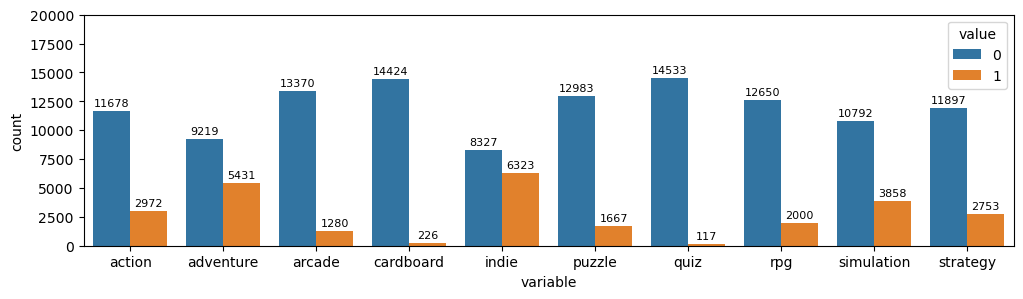

In [40]:
# displaying test set distribution as a proof of validation to our confusion matrices

display(y_test[genre_cols].apply(lambda x: x.value_counts(normalize=True)))

plt.figure(figsize=(12,3))
ax = sns.countplot(x="variable", hue="value", data=pd.melt(y_test[genre_cols]))
ax.set_ylim(0,20000)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2, fontsize=8)

plt.show()

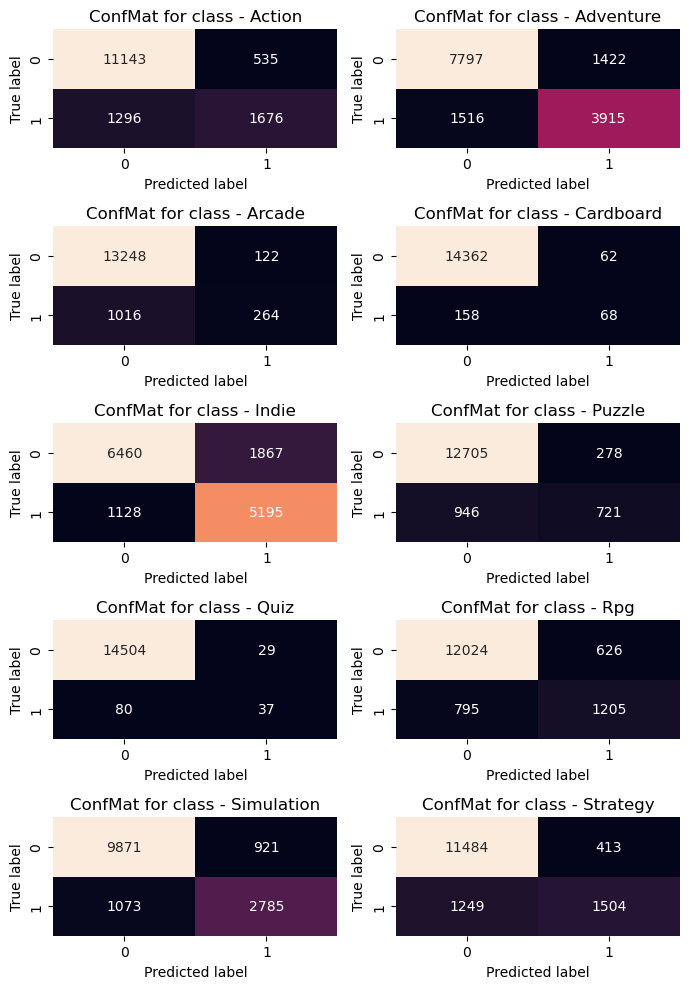

In [41]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("ConfMat for class - " + class_label.capitalize())
    
fig, ax = plt.subplots(5, 2, figsize=(7, 10))
    
for axes, cfs_matrix, label in zip(ax.flatten(), mlb_cm, genre_cols):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()

### 📝 Classification Report

In [42]:
print(metrics.classification_report(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, target_names=genre_cols))

              precision    recall  f1-score   support

      action       0.76      0.56      0.65      2972
   adventure       0.73      0.72      0.73      5431
      arcade       0.68      0.21      0.32      1280
   cardboard       0.52      0.30      0.38       226
       indie       0.74      0.82      0.78      6323
      puzzle       0.72      0.43      0.54      1667
        quiz       0.56      0.32      0.40       117
         rpg       0.66      0.60      0.63      2000
  simulation       0.75      0.72      0.74      3858
    strategy       0.78      0.55      0.64      2753

   micro avg       0.73      0.65      0.69     26627
   macro avg       0.69      0.52      0.58     26627
weighted avg       0.73      0.65      0.68     26627
 samples avg       0.75      0.71      0.69     26627



### 📝 Getting F1 Score

In [43]:
for cat in genre_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.f1_score(actual_df[cat], thresholded_preds[cat])}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_f1_score(torch.tensor(predictions_df[cat].values),torch.tensor(actual_df[cat].values))}")
#     print(f"torchmetrics score(orig): {torchmetrics.functional.classification.binary_f1_score(torch.tensor(thresholded_preds[cat].values),torch.tensor(actual_df[cat].values), threshold=0.5)}")
    print("#" * 30)
    print()

Category: action
Sklearn score: 0.6467296932278604
torchmetrics score: 0.6467297077178955
##############################

Category: adventure
Sklearn score: 0.727154531946508
torchmetrics score: 0.727154552936554
##############################

Category: arcade
Sklearn score: 0.3169267707082833
torchmetrics score: 0.3169267773628235
##############################

Category: cardboard
Sklearn score: 0.38202247191011235
torchmetrics score: 0.3820224702358246
##############################

Category: indie
Sklearn score: 0.7762420620097124
torchmetrics score: 0.7762420773506165
##############################

Category: puzzle
Sklearn score: 0.5408852213053263
torchmetrics score: 0.5408852100372314
##############################

Category: quiz
Sklearn score: 0.40437158469945356
torchmetrics score: 0.40437158942222595
##############################

Category: rpg
Sklearn score: 0.6290785695640826
torchmetrics score: 0.6290785670280457
##############################

Category: simulation
Sk

In [44]:
print(f"Sklearn score(micro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='micro')}")
print(f"torchmetrics score(micro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(macro): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='macro')}")
print(f"torchmetrics score(macro): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='macro')}")

print()
print(f"Sklearn score(weighted): {metrics.f1_score(actual_df[genre_cols].values, thresholded_preds[genre_cols].values, average='weighted')}")
print(f"torchmetrics score(weighted): {torchmetrics.functional.classification.multilabel_f1_score(torch.tensor(thresholded_preds[genre_cols].values),torch.tensor(actual_df[genre_cols].values),num_labels=10,average='weighted')}")

Sklearn score(micro): 0.6910407383831955
torchmetrics score(micro): 0.5803905725479126

Sklearn score(macro): 0.5803905120616097
torchmetrics score(macro): 0.5803905725479126

Sklearn score(weighted): 0.6794894931724721
torchmetrics score(weighted): 0.6794894933700562
